In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
from matplotlib.gridspec import GridSpec

In [23]:
num_train_samples=1000
num_test_samples=1000
#kinematic viscoscity
nu= 0.01/np.pi

In [24]:
#First we build the network class. For this we use a network with two inputs. Input size is of the form (t,x). There is a single output of the shape u(t,x). I have made a network with three hidden layers having 16, 32 and 64 nodes.
class Network:
  @classmethod
  def build(cls, num_inputs=2,layers=[16,32,64],activation='tanh', num_outputs=1):
    #activation function used in the hidden layers is tanh. it has range from -1 to 1. the return type will be a keras model.
    inputs= tf.keras.layers.Input(shape=(num_inputs,))#input layer. tf.keras.Input instantiates the keras tensor. return type will be tensors.
    #hidden layers
    x=inputs
    for layer in layers:
      x=tf.keras.layers.Dense(layer, activation=activation)(x)
    #output layer
    outputs=tf.keras.layers.Dense(num_outputs)(x)
    return tf.keras.models.Model(inputs=inputs,outputs=outputs)


In [25]:
#building model using network class
network=Network.build()
network.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_5 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_6 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 2,769
Trainable params: 2,769
Non-trainable params: 0
_________________________________________________________________


In [26]:
#Now we build the gradient class for our Burger's Equation. This class will be used to compute the first and second order derivatives. model: keras network model. input:x variable, output:output,1st derivative,2nd derivative
class GradientLayer(tf.keras.layers.Layer):
  def __init__(self,model,**kwargs):
    self.model=model
    super().__init__(**kwargs)
  def call(self,x):
    #We use Gradient tape to compute the gradients.
    with tf.GradientTape() as g:
      g.watch(x) #Tensors can be manually watched by invoking the watch method on this context manager if theyre not created by Variable.
      #nesting Gradient tape to find the double derivative
      with tf.GradientTape() as gg: 
        gg.watch(x)
        u = self.model(x)
      du_dtx = gg.batch_jacobian(u, x) # function is useful when target[i,...] is independent of source[j,...] for j != i
      du_dt = du_dtx[..., 0]  # du/dt du/dx
      du_dx = du_dtx[..., 1]
    d2u_dx2 = g.batch_jacobian(du_dx, x)[..., 1]#du/dt d2u/dx2
    return u, du_dt, du_dx, d2u_dx2

In [27]:
#Now we build our PINN class for the equation.
#Attributes:
#network: keras network model with input (t, x) and output u(t, x).
#nu: kinematic viscosity.
#grads: gradient layer.
class PINN:
  def __init__(self, network, nu):
        self.network = network
        self.nu = nu
        self.grads = GradientLayer(self.network)
  def build(self):
        """
        Build a PINN model for Burgers' equation.
        Returns:
            PINN model for the projectile motion with
                input: [ (t, x) relative to equation,
                         (t=0, x) relative to initial condition,
                         (t, x=bounds) relative to boundary condition. Here x=-1 and x=1 will be the boundary conditions. ],
                output: [ u(t,x) relative to equation (must be zero),
                          u(t=0, x) relative to initial condition,
                          u(t, x=bounds) relative to boundary condition ]
        """
        # equation input: (t, x)
        tx_eqn = tf.keras.layers.Input(shape=(2,))
        # initial condition input: (t=0, x)
        tx_ini = tf.keras.layers.Input(shape=(2,))
        # boundary condition input: (t, x=-1) or (t, x=+1)
        tx_bnd = tf.keras.layers.Input(shape=(2,))

        # compute gradients. we use the gradient class previously built.
        u, du_dt, du_dx, d2u_dx2 = self.grads(tx_eqn)

        # equation output being zero
        u_eqn = du_dt + u*du_dx - (self.nu)*d2u_dx2
        # initial condition output for t =0, x=x
        u_ini = self.network(tx_ini) #passing thru the inner network i.e. hidden layers.
        # boundary condition output for x=-1 and x=1 and t=t
        u_bnd = self.network(tx_bnd)

        # build the PINN model for Burgers' equation
        return tf.keras.models.Model(inputs=[tx_eqn, tx_ini, tx_bnd], outputs=[u_eqn, u_ini, u_bnd])
  

In [28]:
#Lets use the PINN class to build our model now

In [29]:
pinn=PINN(network,nu).build()

In [30]:
pinn.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
gradient_layer_1 (GradientLayer ((None, 1), (None, 1 2769        input_6[0][0]                    
__________________________________________________________________________________________________
tf.math.multiply_2 (TFOpLambda) (None, 1)            0           gradient_layer_1[0][0]           
                                                                 gradient_layer_1[0][2]           
__________________________________________________________________________________________________
tf.__operators__.add_1 (TFOpLam (None, 1)            0           gradient_layer_1[0][1]     

In [31]:
#creating training input
tx_eqn=np.random.rand(num_train_samples,2) #t_eqn = 0 to 1
tx_eqn[...,1]=2*tx_eqn[...,1]-1 #x_eqn -1 to 1
tx_ini=2*np.random.rand(num_train_samples,2)-1 #x_ini -1 to 1
tx_ini[...,0]=0 #t_ini=0
tx_bnd=np.random.rand(num_train_samples,2) #t_bnd 0 to 1
tx_bnd[...,1]=2*np.round(tx_bnd[...,1])-1 #x_bnd = -1 or +1

#creating training output
u_eqn=np.zeros((num_train_samples,1)) #u_eqn=0
u_ini = np.sin(-np.pi * tx_ini[..., 1, np.newaxis])    # u_ini = -sin(pi*x_ini)
u_bnd = np.zeros((num_train_samples, 1))               # u_bnd = 0

In [32]:
'''now we impkement the limited memory BFGS algorithm for optimization. 
the bfgs is good for optimising non-linear problems which are unconstrained.
the limited memory BFGS is good when the num of variables if large(about 1000).
'''

class L_BFGS_B:
    """
    Optimize the keras network model using L-BFGS-B algorithm.
    Attributes:
        model: optimization target model.
        samples: training samples.
        factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
               1e7 for moderate accuracy; 10.0 for extremely high accuracy.
        m: maximum number of variable metric corrections used to define the limited memory matrix.
        maxls: maximum number of line search steps (per iteration).
        maxiter: maximum number of iterations.
        metris: log metrics
        progbar: progress bar
    """

    def __init__(self, model, x_train, y_train, factr=1e7, m=50, maxls=50, maxiter=5000):
        """
        Args:
            model: optimization target model.
            samples: training samples.
            factr: convergence condition. typical values for factr are: 1e12 for low accuracy;
                   1e7 for moderate accuracy; 10.0 for extremely high accuracy.
            m: maximum number of variable metric corrections used to define the limited memory matrix.
            maxls: maximum number of line search steps (per iteration).
            maxiter: maximum number of iterations.
        """

        # set attributes
        self.model = model
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        self.factr = factr
        self.m = m
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']
        # initialize the progress bar
        self.progbar = tf.keras.callbacks.ProgbarLogger(
            count_mode='steps', stateful_metrics=self.metrics)
        self.progbar.set_params( {
            'verbose':1, 'epochs':1, 'steps':self.maxiter, 'metrics':self.metrics})

    def set_weights(self, flat_weights):
        """
        Set weights to the model.
        Args:
            flat_weights: flatten weights.
        """

        # get model weights
        shapes = [ w.shape for w in self.model.get_weights() ]
        # compute splitting indices
        split_ids = np.cumsum([ np.prod(shape) for shape in [0] + shapes ])
        # reshape weights
        weights = [ flat_weights[from_id:to_id].reshape(shape)
            for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes) ]
        # set weights to the model
        self.model.set_weights(weights)

    @tf.function
    def tf_evaluate(self, x, y):
        """
        Evaluate loss and gradients for weights as tf.Tensor.
        Args:
            x: input data.
        Returns:
            loss and gradients for weights as tf.Tensor.
        """

        with tf.GradientTape() as g:
            loss = tf.reduce_mean(tf.keras.losses.mse(self.model(x), y))
        grads = g.gradient(loss, self.model.trainable_variables)
        return loss, grads

    def evaluate(self, weights):
        """
        Evaluate loss and gradients for weights as ndarray.
        Args:
            weights: flatten weights.
        Returns:
            loss and gradients for weights as ndarray.
        """

        # update weights
        self.set_weights(weights)
        # compute loss and gradients for weights
        loss, grads = self.tf_evaluate(self.x_train, self.y_train)
        # convert tf.Tensor to flatten ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')

        return loss, grads

    def callback(self, weights):
        """
        Callback that prints the progress to stdout.
        Args:
            weights: flatten weights.
        """
        self.progbar.on_batch_begin(0)
        loss, _ = self.evaluate(weights)
        self.progbar.on_batch_end(0, logs=dict(zip(self.metrics, [loss])))

    def fit(self):
        """
        Train the model using L-BFGS-B algorithm.
        """

        # get initial weights as a flat vector
        initial_weights = np.concatenate(
            [ w.flatten() for w in self.model.get_weights() ])
        # optimize the weight vector
        print('Optimizer: L-BFGS-B (maxiter={})'.format(self.maxiter))
        self.progbar.on_train_begin()
        self.progbar.on_epoch_begin(1)
        scipy.optimize.fmin_l_bfgs_b(func=self.evaluate, x0=initial_weights,
            factr=self.factr, m=self.m, maxls=self.maxls, maxiter=self.maxiter,
            callback=self.callback)
        self.progbar.on_epoch_end(1)
        self.progbar.on_train_end()

In [33]:
#now let us evaluate using the l-bfgs-b algorithm
x_train=[tx_eqn,tx_ini,tx_bnd]#training input
y_train=[u_eqn,u_ini,u_bnd]#training output
lbfgs= L_BFGS_B(model=pinn,x_train=x_train,y_train=y_train)
lbfgs.fit()

Optimizer: L-BFGS-B (maxiter=5000)
5000/5000 [==============================] - 58s 12ms/step


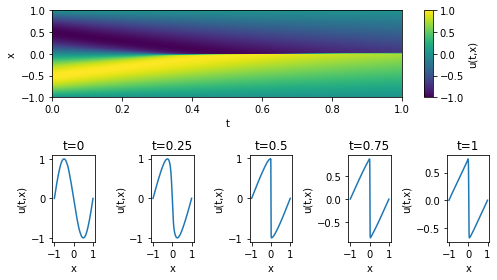

In [34]:
'''Now we will be visualising our results. 
'''
# predict u(t,x) distribution
t_flat = np.linspace(0, 1, num_test_samples)
x_flat = np.linspace(-1, 1, num_test_samples)
t, x = np.meshgrid(t_flat, x_flat)
tx = np.stack([t.flatten(), x.flatten()], axis=-1)
u = network.predict(tx, batch_size=num_test_samples)
u = u.reshape(t.shape)

# plot u(t,x) distribution as a color-map
fig = plt.figure(figsize=(7,4))
gs = GridSpec(2, 5)
plt.subplot(gs[0, :])
plt.pcolormesh(t, x, u)
plt.xlabel('t')
plt.ylabel('x')
cbar = plt.colorbar(pad=0.05, aspect=10)
cbar.set_label('u(t,x)')
cbar.mappable.set_clim(-1, 1)
# plot u(t=const, x) cross-sections
t_cross_sections = [0,0.25, 0.5,0.75,1]
for i, t_cs in enumerate(t_cross_sections):
  plt.subplot(gs[1, i])
  tx = np.stack([np.full(t_flat.shape, t_cs), x_flat], axis=-1)
  u = network.predict(tx, batch_size=num_test_samples)
  plt.plot(x_flat, u)
  plt.title('t={}'.format(t_cs))
  plt.xlabel('x')
  plt.ylabel('u(t,x)')
plt.tight_layout()
plt.show()
    

In [35]:
plt.savefig('output.png')


<Figure size 432x288 with 0 Axes>

In [36]:
from google.colab import files
files.download('output.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>